In [2]:
%matplotlib inline

import datetime as dt
import numpy as np
import pandas as pd
from pandas_datareader import data
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
import scipy.optimize as opt
import scipy.stats as st
import matplotlib.pyplot as plt

In [53]:
train_from_date = '2015-01-01'
train_to_date = '2015-09-30'
test_from_date = '2015-10-01'
test_to_date = '2015-12-31'
symbols = ['AAPL','GOOG','AMZN','FB','MSFT']

train_bench_raw_data =  data.DataReader('SPY','yahoo',train_from_date,train_to_date)
test_bench_raw_data = data.DataReader('SPY','yahoo',test_from_date,test_to_date)

train_stock_raw_data = {}
test_stock_raw_data = {}
for symbol in symbols:
    train_stock_raw_data[symbol] = data.DataReader(symbol,'yahoo',train_from_date,train_to_date)
    test_stock_raw_data[symbol] = data.DataReader(symbol,'yahoo',test_from_date,test_to_date)

weight      :  [[ 1.  0.  0.]]
sharp ratio :  0.131288913205
return      :  0.00295270259795
variance    :  0.000505805218498


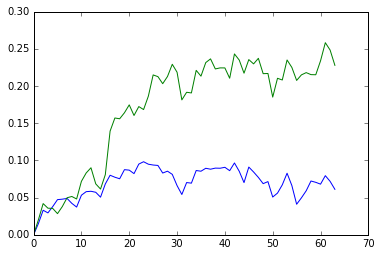

In [65]:
class stock(object):
    def __init__(self,symbol,data):
        self._prices = data['Close'] 
        self._ret = self._prices.pct_change()[1:]
        self._alpha = None
        self._beta = None
    def compute_alpha_beta(self,bench):
        bench_ret = bench['Close'].pct_change()[1:]
        x_ret = np.array(bench_ret.tolist()).reshape(len(bench_ret),1)
        y_ret = np.array(self._ret.tolist()).reshape(len(self._ret),1)
        reg = LinearRegression()
        reg.fit(X=x_ret,y=y_ret)
        self._beta = reg.coef_[0,0]
        self._alpha = reg.intercept_[0]
    def score(self):
        return np.mean(self._ret.tolist()) + (-10)*np.abs(self._beta) + 10*self._alpha
    
class portfolio(object):
    def __init__(self,data):
        self._data = data
        self._n = len(data.columns.values)
        self._w = np.matrix([np.ones(self._n)/self._n])
        self._r = np.matrix([data.mean().values]).T
        self._c = np.matrix(data.cov().values)
    
    def sharpe_ratio(self,w,r,c,rf):
        _w = np.matrix(w)
        _c = np.matrix(c)
        _r = np.matrix(r)
        return ((_w*_r-rf)[0,0])/(np.sqrt(_w*_c*_w.T)[0,0])
    
    def fitness(self,w,r,c,rf=0.0):
        return 1/self.sharpe_ratio(w,r,c,rf)
    
    def fitness_by_target_ret(self,w,r,c,rf=0.0):
        _w = np.matrix(w)
        _c = np.matrix(c)
        _r = np.matrix(r)
        return np.sqrt(_w*_c*_w.T)[0,0] + 100*np.abs((_w*_r)[0,0]-rf)
    
    def show_result(self,x):
        _w = np.matrix(x)
        print 'weight      : ',_w
        print 'sharp ratio : ',self.sharpe_ratio(_w,self._r,self._c,rf=0.0)
        print 'return      : ', (_w * self._r)[0,0]
        print 'variance    : ', (_w * self._c * _w.T)[0,0]
    
    def optimize(self):
        rf = 0.001
        b = [ (0.,1.) for i in range(self._n)]
        c = ({'type':'eq', 'fun': lambda w: sum(w)-1. })
        result = opt.minimize(self.fitness, self._w, 
                              args=(self._r,self._c,rf) ,method='SLSQP',constraints=c,bounds=b)
        self.show_result(result.x)
        
    def optimize_by_target_ret(self,rf=0.0):
        b = [ (0.,1.) for i in range(self._n)]
        c = ({'type':'eq', 'fun': lambda w: sum(w)-1. })
        result = opt.minimize(self.fitness_by_target_ret, self._w, 
                              args=(self._r,self._c,rf) ,method='SLSQP',constraints=c,bounds=b)
        self.show_result(result.x)
    
    def test_forward(self,data):
        start_price = {}
        portfolio_profit = []
        symbols = self._data.columns.values
        for symbol in symbols:
            start_price[symbol] = data[symbol]['Close'].ix[0]
        for i in range(len(data[symbols[0]].index)):
            total_profit = 0
            for symbol in symbols:
                total_profit += 0.33 * (data[symbol]['Close'].ix[i] / start_price[symbol] - 1)
            portfolio_profit.append(total_profit)
        return portfolio_profit
    
class RankingSystem(object):
    def __init__(self,stock_data,bench_data):
        self._bench = bench_data
        self._stocks = {}
        self._stock_scores = {}
        self._portfolio = None
        for symbol in stock_data:
            s = stock(symbol,stock_data[symbol])
            s.compute_alpha_beta(self._bench)
            self._stocks[symbol] = s
            self._stock_scores[symbol] = s.score()
            
    def construct_portfolio(self):
        stock_prices = {}
        ordered_stocks_by_score = np.array(self._stock_scores.keys())[np.argsort(self._stock_scores.values())[::-1]]
        for i in range(3):
            symbol = ordered_stocks_by_score[i]
            stock_prices[symbol] = self._stocks[symbol]._ret
        df = pd.DataFrame(stock_prices)
        df = df.dropna()
        self._portfolio = portfolio(df)
        
    def optimize_portfolio(self):
        self._portfolio.optimize()
    
    def test_forward(self,data,bench_data):
        bench_profit = []
        bench_start_price = bench_data['Close'].ix[0]
        portfolio_profit = self._portfolio.test_forward(data)
        for i in range(len(bench_data['Close'].index)):
            bench_profit.append( bench_data['Close'].ix[i] / bench_start_price -1 )
        return bench_profit,portfolio_profit
    
r = RankingSystem(train_stock_raw_data,train_bench_raw_data)
r.construct_portfolio()
r.optimize_portfolio()
bench_profit,portfolio_profit = r.test_forward(test_stock_raw_data,test_bench_raw_data)

plt.plot(range(len(bench_profit)),bench_profit)
plt.plot(range(len(portfolio_profit)),portfolio_profit)